In [1]:
#Импортируем нужные модули
import numpy as np 
import pandas as pd
import sys, re, csv, codecs

import matplotlib.pyplot as plt
%matplotlib inline

import os
#!pip install tensorflow
#!pip install keras
import keras
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalAveragePooling1D, GlobalMaxPool1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('updated_test.csv')

In [3]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

Теперь создадим словарь всех уникальных слов в нашей выборке с помощью встроенного в Keras класса Tokenizer, он просто создаёт словарь с уникальными токенами и сортирует их по количеству употреблений в наших комментариях

In [4]:
max_features = 100000 #кодироваться в комментариях будут только 100000 наиболее часто встречающихся нам токенов
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

#Кодируем слова в комментариях
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train) 
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [5]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

In [7]:
tokenizer.word_counts

OrderedDict([('explanation', 1771),
             ('why', 17818),
             ('the', 496540),
             ('edits', 9957),
             ('made', 9678),
             ('under', 7001),
             ('my', 45619),
             ('username', 1823),
             ('hardcore', 166),
             ('metallica', 35),
             ('fan', 1025),
             ('were', 15421),
             ('reverted', 3902),
             ('they', 27318),
             ("weren't", 424),
             ('vandalisms', 38),
             ('just', 27806),
             ('closure', 88),
             ('on', 89968),
             ('some', 22586),
             ('gas', 331),
             ('after', 8490),
             ('i', 204397),
             ('voted', 302),
             ('at', 39545),
             ('new', 10665),
             ('york', 912),
             ('dolls', 24),
             ('fac', 321),
             ('and', 224192),
             ('please', 29780),
             ("don't", 22917),
             ('remove', 5140),
          

In [6]:
len(tokenizer.word_index)

210337

Далее сформируем векторы фиксированной длины: слишком короткие вектора заполнятся нулями в конце (padding = 'post', а слишком длинные будут обрезаны(truncating = 'post' с конца) до требуемой длины

In [7]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
totalNumWords[:5]

[47, 18, 42, 114, 13]

In [10]:
totalNumWords_test = [len(one_comment) for one_comment in list_tokenized_test]
totalNumWords_test[:5]

[16, 6, 67, 84, 54]

In [8]:
a = np.array(totalNumWords)
print(a.mean(), a.max(), np.median(a))

67.53010258756291 1403 36.0


In [11]:
a = np.array(totalNumWords_test)
print(a.mean(), a.max(), np.median(a))

61.70308543561849 2142 32.0


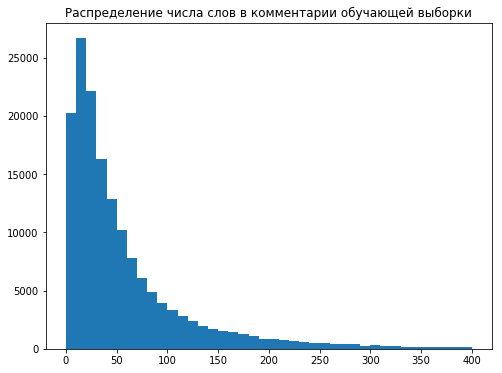

In [40]:
plt.figure(figsize=(8,6))
plt.title("Распределение числа слов в комментарии обучающей выборки")
plt.hist(totalNumWords,bins = np.arange(0,410,10))
fig1 = plt.gcf()
plt.show()
fig1.savefig('Распределение числа слов в комментарии в трейне.png', bbox_inches='tight')

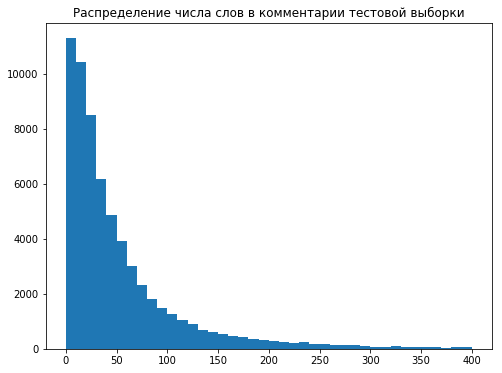

In [39]:
plt.figure(figsize=(8,6))
plt.title("Распределение числа слов в комментарии тестовой выборки")
plt.hist(totalNumWords_test,bins = np.arange(0,410,10))
fig1 = plt.gcf()
plt.show()
fig1.savefig('Распределение длин комментариев в тесте.png', bbox_inches='tight')

Видим, что тексты действительно являются короткими, поэтому нам вполне хватит кодировки ста (maxlen=100) слов в комментарии 

In [14]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen, padding='post', truncating = 'post')
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen, padding='post', truncating = 'post')

In [15]:
X_t[0,]

array([  688,    75,     1,   126,   130,   177,    29,   672,  4511,
       12052,  1116,    86,   331,    51,  2278, 11448,    50,  6864,
          15,    60,  2756,   148,     7,  2937,    34,   117,  1221,
       15190,  2825,     4,    45,    59,   244,     1,   365,    31,
           1,    38,    27,   143,    73,  3462,    89,  3085,  4583,
        2273,   985,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [16]:
X_t.shape

(159571, 100)

In [17]:
y.shape

(159571, 6)

## Построение сетки с архитектурой BiLSTM 

На слой входа у нас попадает лист комментариев, каждый из которых закодирован вектором длины 100:

In [70]:
inp = Input(shape=(maxlen, ))

Затем мы передаем его в слой Embedding'а, где мы проецируем слова в определенное векторное пространство в зависимости от контекста, "расстояния" до близлежащих слов. Мы будем использовать модель векторного представления слов GloVe, которая позволит нам учесть семантические особенности слов, в отличие от того же подхода Bag of Words. Нам также удастся сократить длину вектора слова.

Заготавливаем матрицу для векторного представления GloVe(будем использовать модель с размерностью 50 для векторов-слов, предобученную на корпусе данных из Википедии и GigaWord 5) - подробнее о GloVe: https://nlp.stanford.edu/projects/glove/ 

In [18]:
EMBEDDING_FILE = 'glove.6B.50d.txt'

In [19]:
embed_size = 50

Считываем вектора GloVe как словарь типа слово - вектор

In [20]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE,'r', encoding = 'utf8'))

In [21]:
embeddings_index['mathematics']

array([-1.0468   ,  1.2666   , -0.71321  , -0.43586  ,  0.2787   ,
        0.19846  ,  0.57062  , -1.1086   , -0.90585  ,  0.12501  ,
        0.75718  ,  0.14679  , -0.23584  , -0.49588  , -0.28049  ,
       -0.298    ,  0.12263  ,  1.009    , -0.099603 ,  0.27757  ,
        0.82543  ,  0.0031212,  0.11741  ,  0.33034  ,  0.64692  ,
       -0.64651  , -0.56474  , -1.1533   , -1.0423   ,  0.26482  ,
        2.0228   , -0.62681  , -0.37698  , -1.7588   ,  0.53444  ,
        0.11018  , -0.291    ,  1.84     ,  0.73648  ,  0.98161  ,
        0.3366   , -0.75723  ,  0.087569 ,  1.214    , -0.76718  ,
       -0.17217  ,  1.5288   ,  0.79911  , -0.049526 , -0.13312  ],
      dtype=float32)

Заготавливаем матрицу для эмбеддинга слов. Те слова, которых нет среди полученного словаря весторов Glove, будем инициализировать рандомным вектором, но с теми же статистиками, что и в модели GloVe

In [22]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

In [23]:
all_embs[1,49]

0.30392

In [24]:
all_embs.shape

(400000, 50)

In [25]:
len(tokenizer.word_index)

210337

Создаём матрицу весов

In [26]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)) #GloVe-форму получат 100000 наиболее часто употребляющихся токенов
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():    #пробегаем по изначально созданному словарю токенизатора
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector 
# слова, не найденные в словаре эмбеддинга пропускаются в цикле, и вместо их GloVe-представления
#в строках будут рандомные значения
print('Нулевые эмбеддинги: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Нулевые эмбеддинги: 0


In [27]:
embedding_matrix.shape

(100000, 50)

### Получаем слой Embedding и строим сетку с архитектурой:
1 слой: входной - лист из комментариев, закодированных векторами длины 100 - наши pad_to_sequences

2 слой: эмбеддинги - матрица векторов слов длины 50 для каждого комментария

3 слой: эмбеддинги "скармливаются" LSTM, разверность скрытого состояния - 50. Соответственно, пройдя в двух направлениях на выходе получим канкатенацию - векторы размерности 100, т.к. используем двунаправленную LSTM. Модель очень быстро переобучается, поэтому решено было использовать как LSTM-дропаут входов, так и рекуррентный дропаут скрытых состояний внутри LSTM-блока.

4 слой: max-пулинг - на выходе вектор размерности 100 для каждого комментария

5 слой: полносвязныйс 50 нейронами - снижаем размерность до 50, активационная функция - 'ReLU'

6 слой: дроп-аут для предотвращения переобучения

7 слой: полносвязный с 6 нейронами - получаем искомые вероятности принадлежности к классам, активационная функция - сигмоидальная

In [28]:
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Обучаем модель и проводим валидацию:

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           5000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total para

In [30]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [31]:
batch_size = 32
epochs = 3
X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [32]:
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 151592 samples, validate on 7979 samples
Epoch 1/3
151592/151592 [==============================] - 720s 5ms/step - loss: 0.0600 - acc: 0.9791 - val_loss: 0.0513 - val_acc: 0.9808

 ROC-AUC - epoch: 1 - score: 0.980502
Epoch 2/3
151592/151592 [==============================] - 712s 5ms/step - loss: 0.0438 - acc: 0.9832 - val_loss: 0.0470 - val_acc: 0.9821

 ROC-AUC - epoch: 2 - score: 0.984061
Epoch 3/3
151592/151592 [==============================] - 713s 5ms/step - loss: 0.0385 - acc: 0.9850 - val_loss: 0.0467 - val_acc: 0.9831

 ROC-AUC - epoch: 3 - score: 0.984802


## Предикт

In [36]:
predictions = model.predict(X_te)

In [37]:
print ("ROC-AUC: %0.5f " % roc_auc_score(y_te, predictions))

ROC-AUC: 0.97797 


In [ ]:
epochRange = np.arange(1,3,1)
plt.plot(epochRange,hist.history['loss'])
plt.plot(epochRange,hist.history['val_loss'])
plt.title('Training Vs Validation лосс для модели BiLSTM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()